In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tensorflow.keras.callbacks import Callback

2024-08-22 00:29:52.694931: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-22 00:29:52.697430: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 00:29:52.738665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 00:29:52.738710: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 00:29:52.740776: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
def generate_data(num_points=100):
    # Generate points along a line y = x
    x = np.linspace(0, 10, num_points)
    # Introduce some noise into the x coordinates
    x += np.random.normal(scale=1.0, size=x.shape)
    # Labels are 0 if below y=x, 1 if above
    y = np.random.randint(0, 2, size=(num_points, 1))
    # Adjust y positions to separate classes more clearly
    y_positions = x + (3 * (y[:, 0] - 0.5))
    # Add noise to y positions
    y_positions += np.random.normal(scale=0.8, size=y_positions.shape)

    return x.reshape(-1, 1), y, y_positions.reshape(-1, 1)

x_train, y_train, y_positions = generate_data()

# Double the data by adding the max of x_train to x_train and appending; then double the y_train
x_train = np.concatenate([x_train, x_train + x_train.max()])
y_train = np.concatenate([y_train, y_train[::-1]])
y_positions = np.concatenate([y_positions, y_positions[::-1]])

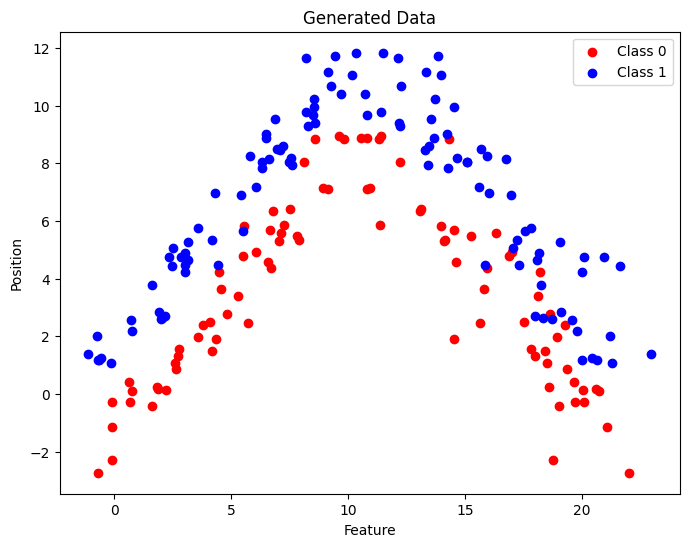

In [4]:
# Plotting the data
plt.figure(figsize=(8, 6))
plt.scatter(x_train[y_train[:, 0] == 0], y_positions[y_train[:, 0] == 0], color='red', label='Class 0')
plt.scatter(x_train[y_train[:, 0] == 1], y_positions[y_train[:, 0] == 1], color='blue', label='Class 1')
plt.xlabel('Feature')
plt.ylabel('Position')
plt.title('Generated Data')
plt.legend()
plt.show()

In [5]:
class DecisionBoundaryCallback(Callback):
    def __init__(self, grid, xx, yy):
        super().__init__()
        self.grid = grid
        self.xx = xx
        self.yy = yy
        self.boundaries = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict over the grid
        preds = self.model.predict(self.grid).reshape(self.xx.shape)
        # Extract the contour line at decision boundary (0.5)
        # and store the vertices of the contour path
        contour = plt.contour(self.xx, self.yy, preds, levels=[0.5])
        paths = contour.collections[0].get_paths()
        if paths:
            self.boundaries.append(paths[0].vertices)  # Store only the first path
        plt.close() 

In [6]:
x_range = np.linspace(x_train.min(), x_train.max(), 300)
y_range = np.linspace(y_positions.min(), y_positions.max(), 300)
xx, yy = np.meshgrid(x_range, y_range)
grid = np.c_[xx.ravel(), yy.ravel()]

# Initialize the callback with the same grid used for predictions
decision_boundary_callback = DecisionBoundaryCallback(grid, xx, yy)

In [7]:
class LearningRateDecayCallback(Callback):
    def __init__(self, decay_rate, epochs_per_decay=10, min_lr=0.0001):
        super().__init__()
        self.decay_rate = decay_rate

    def on_epoch_start(self, epoch, logs=None):
        if epoch > 0 and epoch % self.epochs_per_decay == 0:
            current_lr = self.model.optimizer.lr.read_value().numpy()
            new_lr = current_lr * self.decay_rate
            if new_lr > self.min_lr:
                self.model.optimizer.lr.assign(new_lr)

learning_rate_decay_callback = LearningRateDecayCallback(decay_rate=0.6, epochs_per_decay=12, min_lr=0.0001)

In [8]:
# Model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation='relu', input_shape=(2,)),
    tf.keras.layers.Dense(5, activation='linear'),
    tf.keras.layers.Dense(5, activation='exponential'),
    tf.keras.layers.Dense(2, activation='linear'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [9]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="binary_crossentropy", metrics=['accuracy'])

In [10]:
# Train the model
model.fit(np.append(x_train, y_positions, axis=1), y_train, epochs=50, callbacks=[learning_rate_decay_callback, decision_boundary_callback])

Epoch 1/50
7/7 [==============================] - 4s 628ms/step - loss: 65.1083 - accuracy: 0.5500
Epoch 2/50
 104/2813 [>.............................] - ETA: 2s : 8.3172 - accuracy: 0.4

/tmp/ipykernel_26614/4004394242.py:15: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  paths = contour.collections[0].get_paths()


7/7 [==============================] - 3s 571ms/step - loss: 4.4369 - accuracy: 0.5600
Epoch 3/50
7/7 [==============================] - 4s 608ms/step - loss: 1.1469 - accuracy: 0.5750
Epoch 4/50
7/7 [==============================] - 3s 569ms/step - loss: 0.9635 - accuracy: 0.5650
Epoch 5/50
7/7 [==============================] - 3s 565ms/step - loss: 0.6273 - accuracy: 0.5800
Epoch 6/50
7/7 [==============================] - 4s 584ms/step - loss: 0.5613 - accuracy: 0.5950
Epoch 7/50
7/7 [==============================] - 4s 587ms/step - loss: 0.5538 - accuracy: 0.6050
Epoch 8/50
7/7 [==============================] - 3s 571ms/step - loss: 0.5275 - accuracy: 0.5900
Epoch 9/50
7/7 [==============================] - 3s 567ms/step - loss: 0.5162 - accuracy: 0.6250
Epoch 10/50
7/7 [==============================] - 3s 566ms/step - loss: 0.5082 - accuracy: 0.6650
Epoch 11/50
7/7 [==============================] - 3s 568ms/step - loss: 0.4944 - accuracy: 0.6800
Epoch 12/50
7/7 [============

2813/2813 [==============================] - 3s 1ms/step


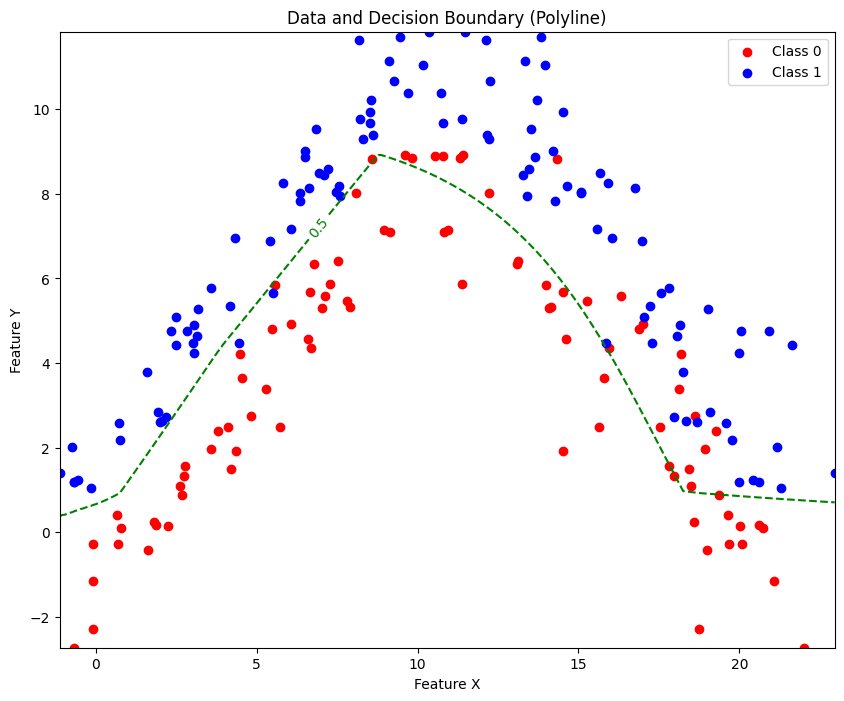

In [11]:
# Generate a grid of points
x_range = np.linspace(x_train.min(), x_train.max(), 300)
y_range = np.linspace(y_positions.min(), y_positions.max(), 300)
xx, yy = np.meshgrid(x_range, y_range)

# Prepare and predict over the grid
grid = np.c_[xx.ravel(), yy.ravel()]
preds = model.predict(grid).reshape(xx.shape)

# Plot the original data
plt.figure(figsize=(10, 8))
plt.scatter(x_train[y_train[:, 0] == 0], y_positions[y_train[:, 0] == 0], color='red', label='Class 0')
plt.scatter(x_train[y_train[:, 0] == 1], y_positions[y_train[:, 0] == 1], color='blue', label='Class 1')

# Contour plot for the decision boundary
contours = plt.contour(xx, yy, preds, levels=[0.5], colors='green', linestyles='--')
plt.clabel(contours, inline=True, fontsize=10, fmt='0.5')

plt.xlabel('Feature X')
plt.ylabel('Feature Y')
plt.title('Data and Decision Boundary (Polyline)')
plt.legend()
plt.show()

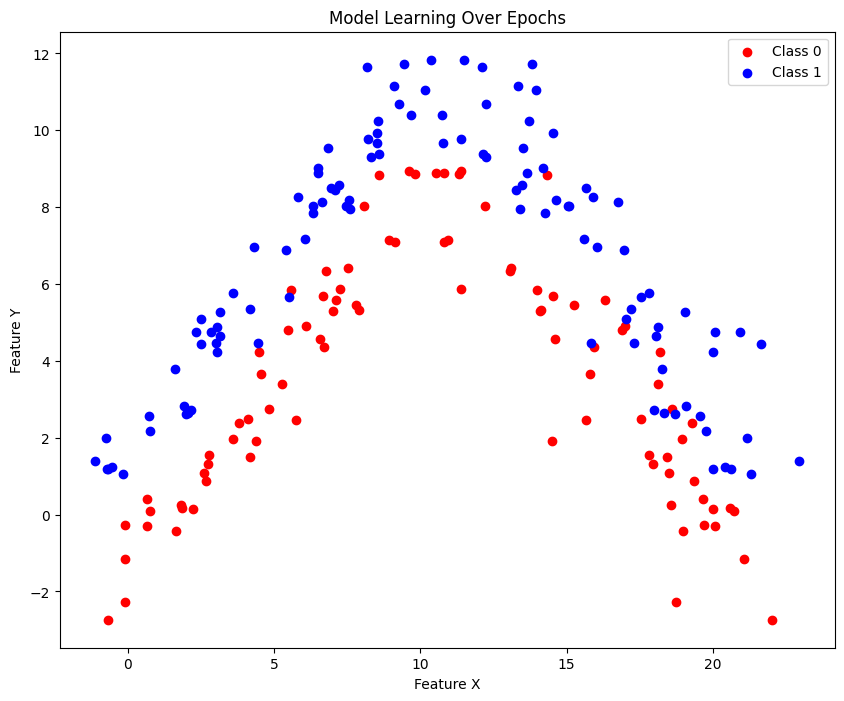

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(x_train[y_train[:, 0] == 0], y_positions[y_train[:, 0] == 0], color='red', label='Class 0')
ax.scatter(x_train[y_train[:, 0] == 1], y_positions[y_train[:, 0] == 1], color='blue', label='Class 1')
ax.set_xlabel('Feature X')
ax.set_ylabel('Feature Y')
ax.set_title('Model Learning Over Epochs')
ax.legend()

# Prepare a line object; initially no data
line, = ax.plot([], [], 'g--', linewidth=2)  # Green dashed line for decision boundary

# Initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return line,

# Animation update function
def update(i):
    vertices = decision_boundary_callback.boundaries[i]
    line.set_data(vertices[:, 0], vertices[:, 1])
    return line,

# Create animation
ani = FuncAnimation(fig, update, frames=len(decision_boundary_callback.boundaries), init_func=init, blit=True, repeat=False)

plt.show()

In [15]:
ani.save('decision_boundary_line_8fps.gif', writer='pillow', fps=8)